In [1]:
import pandas as pd
import numpy as np

import datetime
import time

import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seed(3)
#
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(3)


## Data

In [3]:
Timeseries = pd.read_csv("timeseries.csv")
Timeseries.shape

(218, 206704)

## Data splitting

> - **Training data (70%)**: This set is used to adjust the model weights. The model "learns" from this data.

> - **Validation data (20%)**: This set is used to evaluate the performance of the model during the training process and tune hyperparameters like learning rate, model structure, etc. This set helps to avoid the overfitting.

> - **Testing data (10%)**: This set is used just at the end, once the model has been trained to evaluate its performance in completely new data and get a final estimation of its capacity of generalization.

In [4]:
df = Timeseries

total_rows = df.shape[0]
train_end = int(total_rows * 0.8)
validation_end = int(total_rows * 0.9)

XTrain = df.iloc[:train_end]
XValidation = df.iloc[train_end:validation_end]
XTest = df.iloc[validation_end:]

In [5]:
Timeseries =Timeseries.values.astype('float32')
XTrain = XTrain.values.astype('float32')
XValidation = XValidation.values.astype('float32')
XTest = XTest.values.astype('float32')

In [6]:
print(len(Timeseries), "(100%)")
print(len(XTrain), f"({len(XTrain)/len(Timeseries)*100:.3f}%)")
print(len(XValidation), f"({len(XValidation)/len(Timeseries)*100:.3f}%)")
print(len(XTest), f"({len(XTest)/len(Timeseries)*100:.3f}%)")

218 (100%)
174 (79.817%)
22 (10.092%)
22 (10.092%)


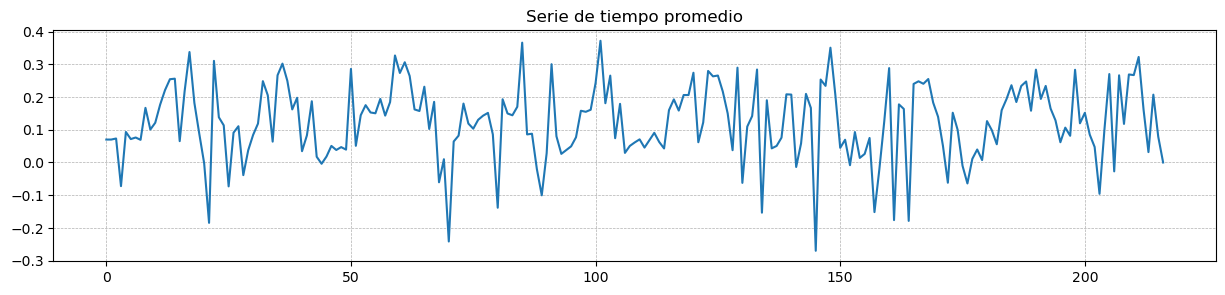

In [7]:
plt.figure(figsize=(15,3))

plt.title("Serie de tiempo promedio")
plt.plot(np.mean(Timeseries[1:, :], axis=1))

plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

In [8]:
print(np.std(np.mean(Timeseries, axis=1)))

0.1157698


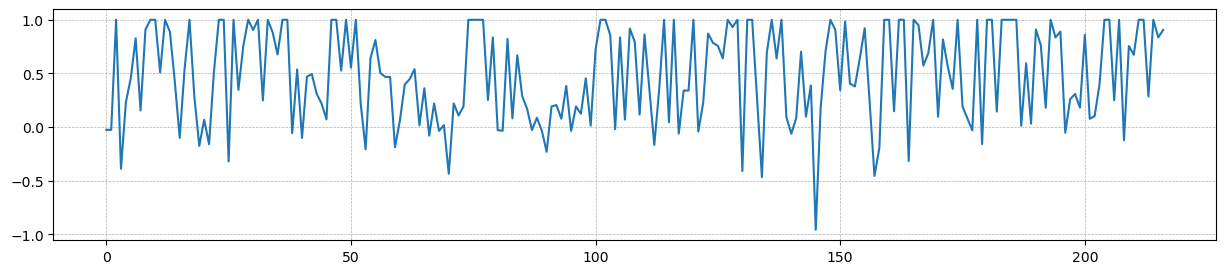

In [9]:
plt.figure(figsize=(15,3))

plt.plot(Timeseries[1:, 99523])

plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

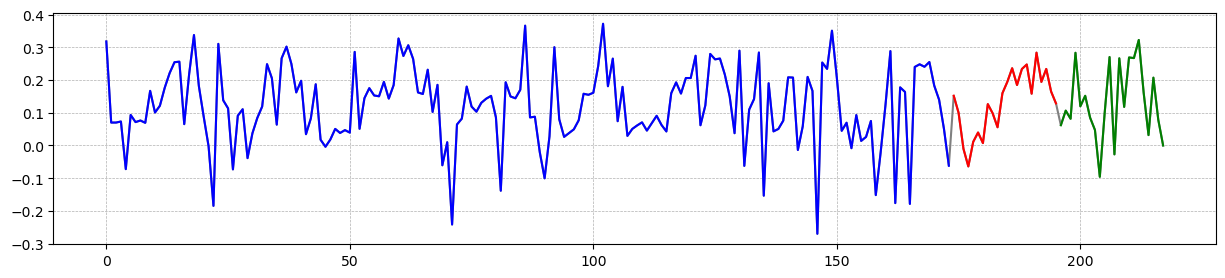

In [10]:
plt.figure(figsize=(15,3))

plt.plot(np.mean(Timeseries, axis=1), color='gray')
plt.plot(np.mean(XTrain, axis=1), color='blue')
plt.plot(np.arange(len(XTrain), len(XTrain) + len(XValidation)), np.mean(XValidation, axis=1), color='red')
plt.plot(np.arange(len(XTrain) + len(XValidation), len(XTrain) + len(XValidation) + len(XTest)), np.mean(XTest, axis=1), color='green')

plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

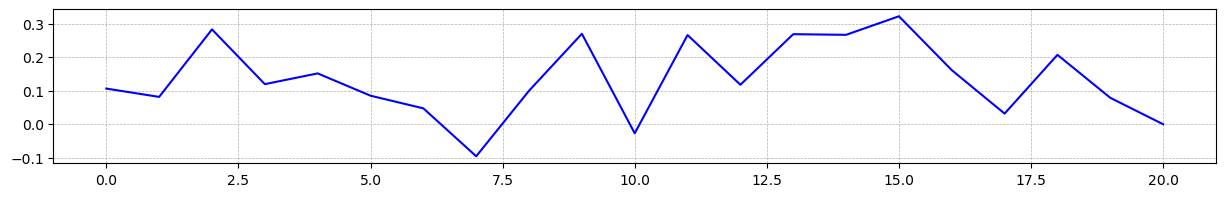

In [11]:
plt.figure(figsize=(15,2))
plt.plot(np.mean(XTest[1:, :], axis=1), color='blue')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

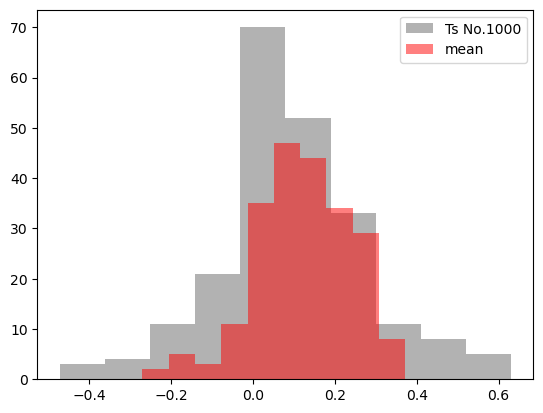

In [12]:
plt.hist(Timeseries[:,10000], alpha=.3, label="Ts No.1000", color='k')
plt.hist(np.mean(Timeseries, axis=1), alpha=.5, label="mean", color='red')

plt.legend()

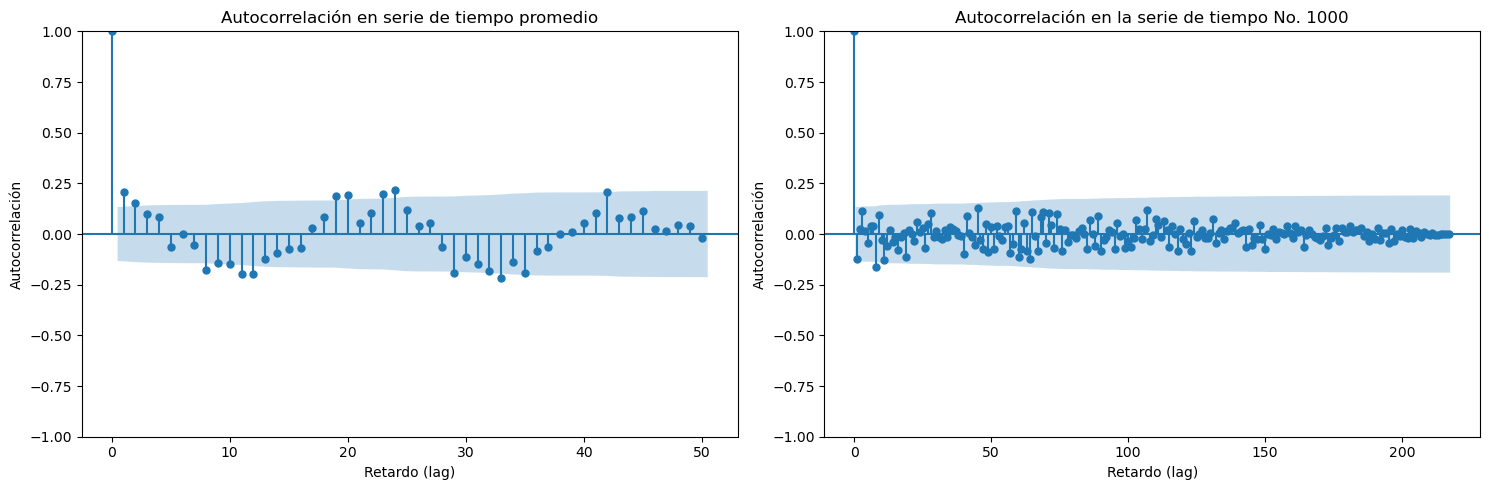

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(np.mean(Timeseries, axis=1), lags=50, ax=ax[0])  
ax[0].set_title('Autocorrelación en serie de tiempo promedio')
ax[0].set_xlabel('Retardo (lag)')
ax[0].set_ylabel('Autocorrelación')

plot_acf(Timeseries[:,10000], lags=len(Timeseries)-1, ax=ax[1])  
ax[1].set_title('Autocorrelación en la serie de tiempo No. 1000')
ax[1].set_xlabel('Retardo (lag)')
ax[1].set_ylabel('Autocorrelación')

plt.tight_layout()
plt.show()

## Processing data

In [14]:
#Escalamos para que cada serie de tiempo aporte de la misma manera los patrones presentes
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(Timeseries)

Timeseries = scaler.transform(Timeseries)
XTrain = scaler.transform(XTrain)
XValidation = scaler.transform(XValidation)
XTest = scaler.transform(XTest)

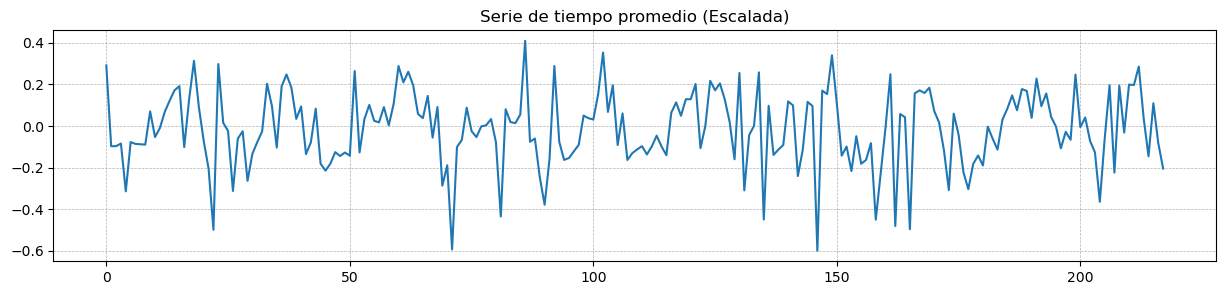

In [15]:
plt.figure(figsize=(15,3))

plt.title("Serie de tiempo promedio (Escalada)")
plt.plot(np.mean(Timeseries, axis=1))

plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

### Look back

We need to prepare the data so that each sequence size in ``X`` (input sequence) has a corresponding value in ``y`` (output values correspond to each sequence) that represents the next point in the time series. This structure is necesary to train a model that can learn to predict the next value based on a sequence of previous values.

In the function ```create_lookback```, the parameter ``lookback`` is the sliding window size,i.e., the number of previous temporal steps useds like characteeristics to predict the next value. 

In [16]:
def create_lookback(dataset, lookback, device):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        window = dataset[i:(i + lookback)]
        after_window = dataset[i + lookback]
        X.append(window)
        y.append(after_window)
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32).to(device)
    return X_tensor, y_tensor

In [17]:
'''Preparing Data'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# device = "cpu"

Using device: cuda


In [18]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4050 Laptop GPU'

##### Example to understand ``create_lookback``

In [19]:
dataset = [1,2,3,4,5,6,7,8,9,10]
a,b = create_lookback(dataset, 2, device)
a,b

(tensor([[1., 2.],
         [2., 3.],
         [3., 4.],
         [4., 5.],
         [5., 6.],
         [6., 7.],
         [7., 8.],
         [8., 9.]], device='cuda:0'),
 tensor([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10.], device='cuda:0'))

In [20]:
for _ in range(len(b)):
    print("x:", a.cpu().numpy()[_][:], "--> y:", b.cpu().numpy()[_])

x: [1. 2.] --> y: 3.0
x: [2. 3.] --> y: 4.0
x: [3. 4.] --> y: 5.0
x: [4. 5.] --> y: 6.0
x: [5. 6.] --> y: 7.0
x: [6. 7.] --> y: 8.0
x: [7. 8.] --> y: 9.0
x: [8. 9.] --> y: 10.0


The first window recived as input in the model is ``[1, 2, 3]`` and it learns to predict ``4`` as the output, and so on until output ``10``.

#### Applying the funtion in our dataset

In [21]:
lookback = 2
XTrain_tensor, TTrain_tensor = create_lookback(XTrain, lookback, device)
XValidation_tensor, TValidation_tensor = create_lookback(XValidation, lookback, device)
XTest_tensor, TTest_tensor = create_lookback(XTest, lookback, device)

Timeseries_tensor, TTimeseries_tensor = create_lookback(Timeseries, lookback, device)

print(f"XTrain_tensor shape: {XTrain_tensor.shape}, \nTTrain_tensor shape: {TTrain_tensor.shape}")
print(f"\nXValidation_tensor shape: {XValidation_tensor.shape}, \nTValidation_tensor shape: {TValidation_tensor.shape}")
print(f"\nXTest_tensor shape: {XTest_tensor.shape}, \nTTest_tensor shape: {TTest_tensor.shape}")

XTrain_tensor shape: torch.Size([172, 2, 206704]), 
TTrain_tensor shape: torch.Size([172, 206704])

XValidation_tensor shape: torch.Size([20, 2, 206704]), 
TValidation_tensor shape: torch.Size([20, 206704])

XTest_tensor shape: torch.Size([20, 2, 206704]), 
TTest_tensor shape: torch.Size([20, 206704])


**Remember**: ``Xtrain_tensor``, ``XValidation_tensor`` and ``XTest_tensor`` represent the input sequence that the model will use to make predictions.

### Batch data management

In [22]:
train_dataset = TensorDataset(XTrain_tensor, TTrain_tensor)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, worker_init_fn=seed_worker, generator=g)

val_dataset = TensorDataset(XValidation_tensor, TValidation_tensor)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False, worker_init_fn=seed_worker, generator=g)

test_dataset = TensorDataset(XTest_tensor, TTest_tensor)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, worker_init_fn=seed_worker, generator=g)

- `TensorDataset` is a class in _PyTorch_ that allows grouping multiple tensors together in a dataset. Here, take two tensors: ``XTrain_tensor`` (features) and ``TTrain tensor`` (target) and combines them into a sigle dataset that can be used by ``DataLoader``

- ``DataLoader`` is other class in _Pytorch_, used to manipulate the datasets creating batches,  allowing multiple samples to be processed by the CPU or GPU at once. ``shuffle=True`` is used to ramdomize the training set, reducing overfitting. This ensures that the data is shuffled at the beginning of each epoch, which is useful in training to prevent the model from learning patterns based on the order of the data. On the other hand, it is not necessary to shuffle the data for validation and test dataset, so ``shuffle=False`` is used.

In [23]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

35
4
4


## LSTM Model

In [24]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.ModuleList([
            nn.LSTM(input_size=206704, hidden_size=160, batch_first=True),
            nn.Dropout(p=0.25),
            nn.LSTM(input_size=160, hidden_size=105, batch_first=True),
            nn.Dropout(p=0.2),
            nn.LSTM(input_size=105, hidden_size=110, batch_first=True),
            nn.Dropout(p=0.3)
        ])
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=110, out_features=155),
            nn.Linear(in_features=155, out_features=220),
            nn.Linear(in_features=220, out_features=65), 
            nn.Linear(in_features=65, out_features=65), 
            nn.Linear(in_features=65, out_features=206704), 
        )
    
    def forward(self, x):
        x, _ = self.lstm[0](x)  
        x = self.lstm[1](x)    
        x, _ = self.lstm[2](x) 
        x = self.lstm[3](x)     
        x, _ = self.lstm[4](x)  
        x = self.lstm[5](x)     
        
        # fully connected layers
        x = self.fc(x[:, -1, :])
        
        return x

model = LSTM()
print(model)

LSTM(
  (lstm): ModuleList(
    (0): LSTM(206704, 160, batch_first=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): LSTM(160, 105, batch_first=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): LSTM(105, 110, batch_first=True)
    (5): Dropout(p=0.3, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=110, out_features=155, bias=True)
    (1): Linear(in_features=155, out_features=220, bias=True)
    (2): Linear(in_features=220, out_features=65, bias=True)
    (3): Linear(in_features=65, out_features=65, bias=True)
    (4): Linear(in_features=65, out_features=206704, bias=True)
  )
)


## Model Training and Evaluation

In [28]:
model.to(device)

LSTM(
  (lstm): ModuleList(
    (0): LSTM(206704, 160, batch_first=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): LSTM(160, 105, batch_first=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): LSTM(105, 110, batch_first=True)
    (5): Dropout(p=0.3, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=110, out_features=155, bias=True)
    (1): Linear(in_features=155, out_features=220, bias=True)
    (2): Linear(in_features=220, out_features=65, bias=True)
    (3): Linear(in_features=65, out_features=65, bias=True)
    (4): Linear(in_features=65, out_features=206704, bias=True)
  )
)

Epoch [5/70] - Training Loss: 0.2599, Validation Loss: 0.2219, Learning Rate: 0.001000
Validation RMSE: 0.18014374


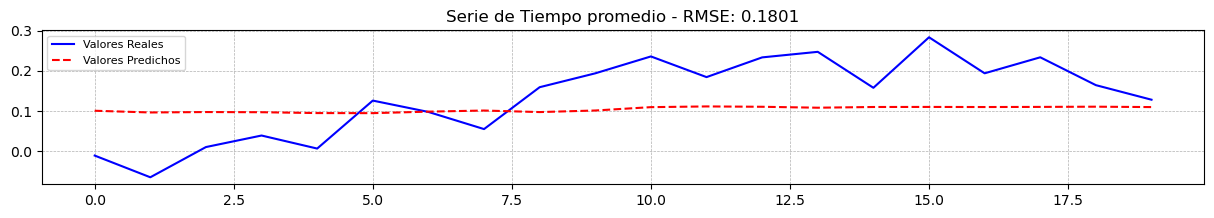


Epoch [10/70] - Training Loss: 0.2527, Validation Loss: 0.2077, Learning Rate: 0.001000
Validation RMSE: 0.16993412


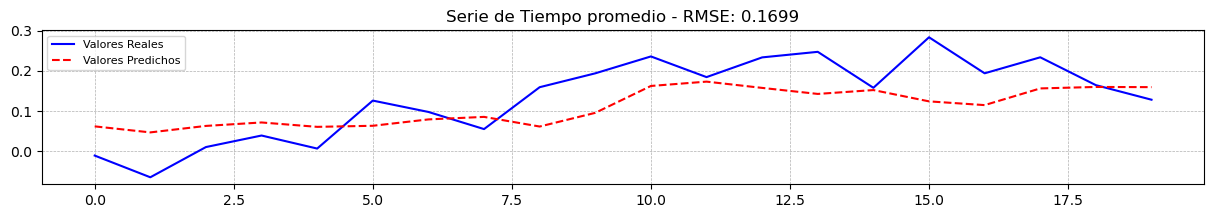


Epoch [15/70] - Training Loss: 0.2445, Validation Loss: 0.2034, Learning Rate: 0.001000
Validation RMSE: 0.167301


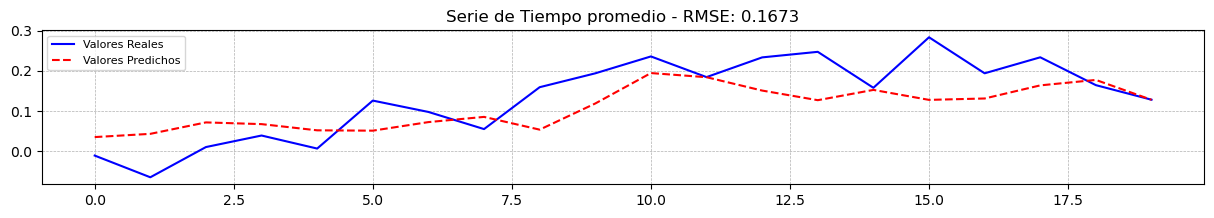


Epoch [20/70] - Training Loss: 0.2380, Validation Loss: 0.2049, Learning Rate: 0.001000
Validation RMSE: 0.16791332


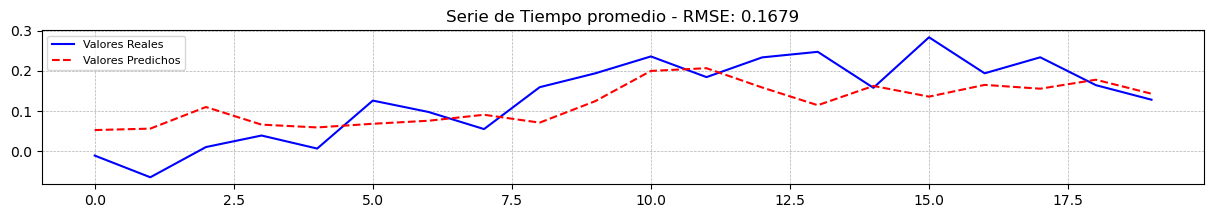


Epoch [25/70] - Training Loss: 0.2333, Validation Loss: 0.2070, Learning Rate: 0.001000
Validation RMSE: 0.16878606


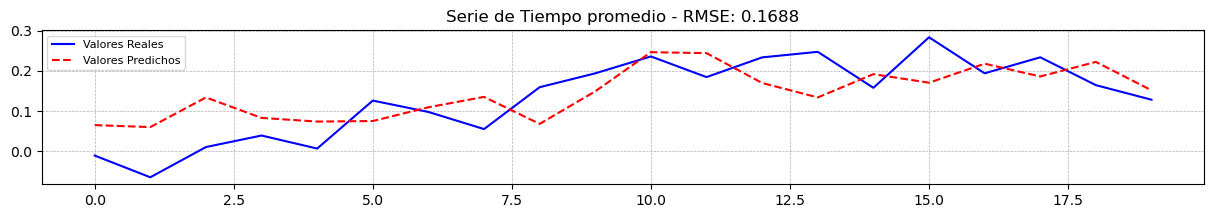


Epoch [30/70] - Training Loss: 0.2274, Validation Loss: 0.2071, Learning Rate: 0.001000
Validation RMSE: 0.16987284


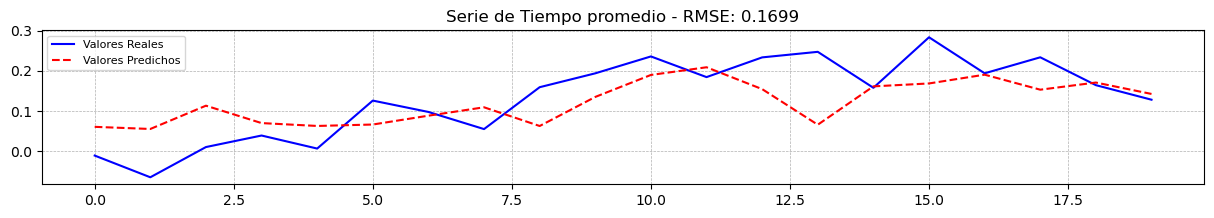


Epoch [35/70] - Training Loss: 0.2271, Validation Loss: 0.2061, Learning Rate: 0.001000
Validation RMSE: 0.1699635


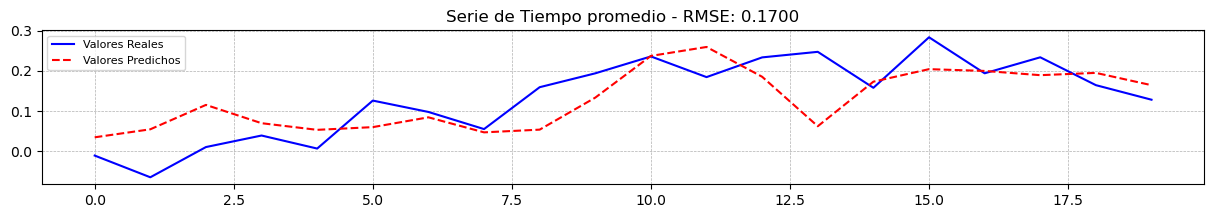


Early stopping! in epoch 38
Training Loss: 0.2282, Validation Loss: 0.2126, Learning Rate: 0.001000
Validation RMSE: 0.17419533     std: 0.070047125
Execution time: 174.67 seconds


In [29]:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# loss_fn =  nn.MSELoss()
loss_fn = nn.L1Loss()
# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)
 
n_epochs = 70
early_stop_count = 0
min_val_loss = float('inf')
train_hist = []
val_hist = [] 
test_loss = None  # To store the final loss in the test set

start_time = time.time()
for epoch in range(n_epochs):

    total_loss = 0.0
    
    ''' Training Phase'''
    model.train() 
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad() # resets the gradients before each optimization step
        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch)
        loss.backward() # computes the gradients with respect to the loss function
        optimizer.step() # updates the model parameters using the computed gradients

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    ''' Validation Phase'''
    model.eval()
    total_val_loss = 0.0 
    y_predicted = [] # for calculate rmse in validation data (our goal is to reduce it)
    y_observed = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            y_predicted.append(y_pred.cpu().numpy())
            y_observed.append(y_batch.cpu().numpy())

            val_loss = loss_fn(y_pred, y_batch)
            total_val_loss += val_loss.item()
    
    average_val_loss = total_val_loss / len(val_loader)
    val_hist.append(average_val_loss)
    #scheduler.step(average_val_loss)

    predicted = np.concatenate(y_predicted, axis=0)
    observed = np.concatenate(y_observed, axis=0)
    
    predicted = scaler.inverse_transform(predicted)
    observed = scaler.inverse_transform(observed)
    
    rmses = []
    for i in range(predicted.shape[1]):
        rmse = np.sqrt(np.mean((predicted[:, i] - observed[:, i])**2))
        rmses.append(rmse)
    rmse_mean = np.mean(rmses)


    if average_val_loss < min_val_loss:
        min_val_loss = average_val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 20:
        print(f'Early stopping! in epoch {epoch+1}')
        print(f'Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Learning Rate: {current_lr:.6f}')
        print(f'Validation RMSE:', rmse_mean, "    std:", np.std(rmses))

        break

    
    if (epoch+1) % 5 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{n_epochs}] - Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}, Learning Rate: {current_lr:.6f}')
        print(f'Validation RMSE:', rmse_mean)
        plt.figure(figsize=(15, 2))
        plt.plot(np.mean(observed, axis=1), label='Valores Reales', color='blue')
        plt.plot(np.mean(predicted, axis=1), label='Valores Predichos', linestyle='--', color="red")
        plt.title(f'Serie de Tiempo promedio - RMSE: {rmse_mean:.4f}')
        plt.legend(fontsize=8)
        plt.grid(linestyle = '--', linewidth = 0.5)
        plt.show()
        print()
        
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.2f} seconds")

In [30]:
print(predicted.shape)
print(observed.shape)

(20, 206704)
(20, 206704)


In [31]:
total_loss

7.986073553562164

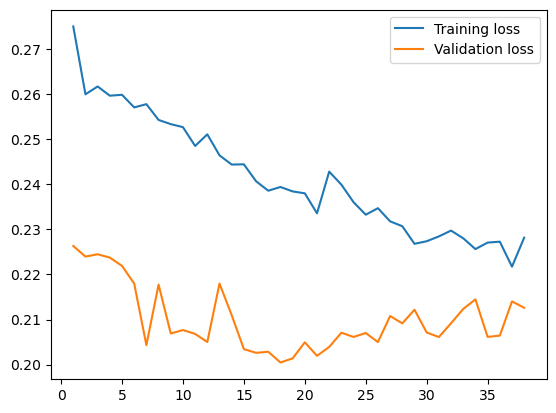

In [32]:
x = np.linspace(1,len(val_hist),len(val_hist))
plt.plot(x, train_hist, scalex=True, label="Training loss")
plt.plot(x, val_hist, label="Validation loss")
plt.legend()

plt.show()

## Evaluation on Test Set

Mejor Serie de Tiempo (Serie 169154) - RMSE: 0.0739
Peor Serie de Tiempo (Serie 15607) - RMSE: 0.5622


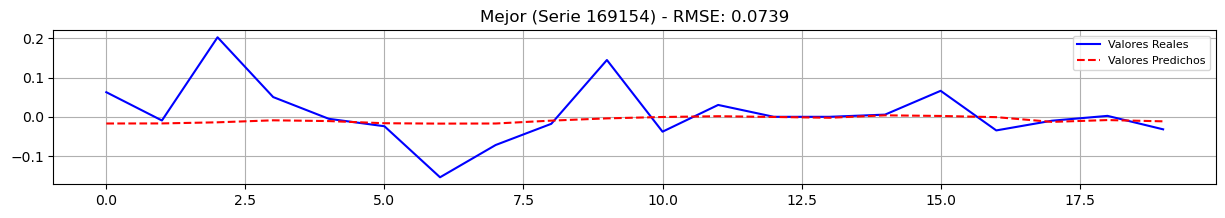

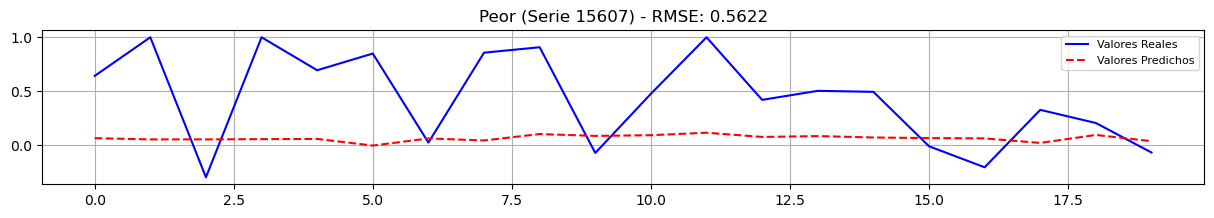

RMSE promedio: 0.21734223     std: 0.06342427


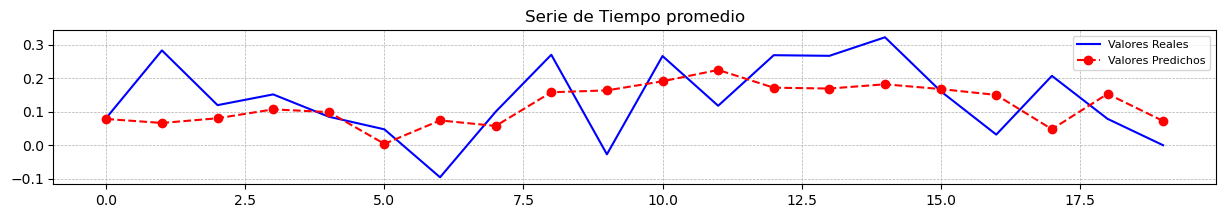

In [33]:
y_predicted = []
y_observed = []

# Final Evaluation on Test Set
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)

        # y_predicted.extend(y_pred.cpu().numpy())
        y_predicted.append(y_pred.cpu().numpy())
        y_observed.append(y_batch.cpu().numpy())

predicted = np.concatenate(y_predicted, axis=0)
observed = np.concatenate(y_observed, axis=0)

predicted = scaler.inverse_transform(predicted)
observed = scaler.inverse_transform(observed)

# Calculamos el RMSE por cada serie de tiempo
rmses = []
for i in range(predicted.shape[1]):
    rmse = np.sqrt(np.mean((predicted[:, i] - observed[:, i])**2))
    rmses.append(rmse)

# Mejor y peor RMSE
best_rmse_index = np.argmin(rmses)
worst_rmse_index = np.argmax(rmses)

print(f'Mejor Serie de Tiempo (Serie {best_rmse_index+1}) - RMSE: {rmses[best_rmse_index]:.4f}')
print(f'Peor Serie de Tiempo (Serie {worst_rmse_index+1}) - RMSE: {rmses[worst_rmse_index]:.4f}')

plt.figure(figsize=(15, 2))
plt.plot(observed[:, best_rmse_index], label='Valores Reales', color='blue')
plt.plot(predicted[:, best_rmse_index], label='Valores Predichos', linestyle='--', color="red")
plt.title(f'Mejor (Serie {best_rmse_index+1}) - RMSE: {rmses[best_rmse_index]:.4f}')
plt.legend(fontsize=8)
plt.grid()
plt.show()

plt.figure(figsize=(15, 2))
plt.plot(observed[:, worst_rmse_index], label='Valores Reales', color='blue')
plt.plot(predicted[:, worst_rmse_index], label='Valores Predichos', linestyle='--', color="red")
plt.title(f'Peor (Serie {worst_rmse_index+1}) - RMSE: {rmses[worst_rmse_index]:.4f}')
plt.legend(fontsize=8)
plt.grid()
plt.show()

print("RMSE promedio:", np.mean(rmses), "    std:", np.std(rmses))

plt.figure(figsize=(15, 2))
plt.plot(np.mean(observed, axis=1), label='Valores Reales', color='blue')
plt.plot(np.mean(predicted, axis=1), label='Valores Predichos', linestyle='--', marker='o', color="red")
plt.title(f'Serie de Tiempo promedio')
plt.legend(fontsize=8)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

### Forecast with all data

Mejor Serie de Tiempo (Serie 52829) - RMSE: 0.1137
Peor Serie de Tiempo (Serie 150900) - RMSE: 0.4354


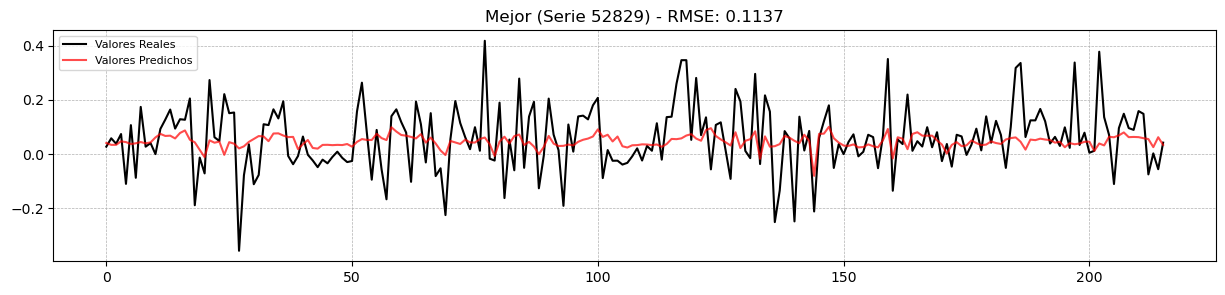

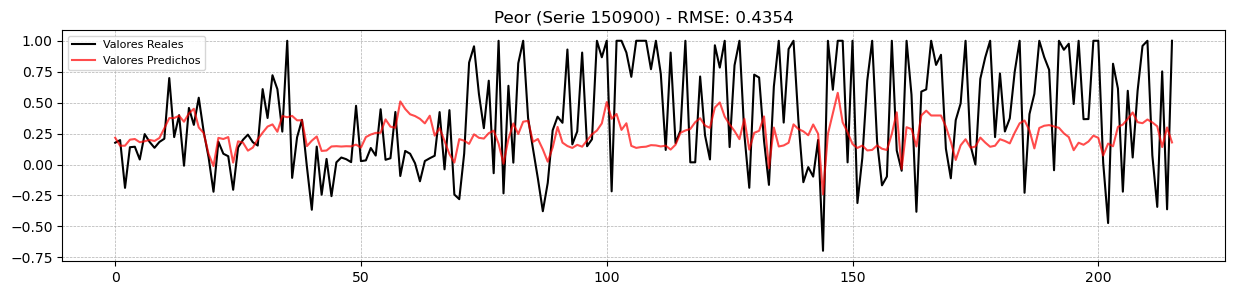

RMSE promedio:  0.18555185


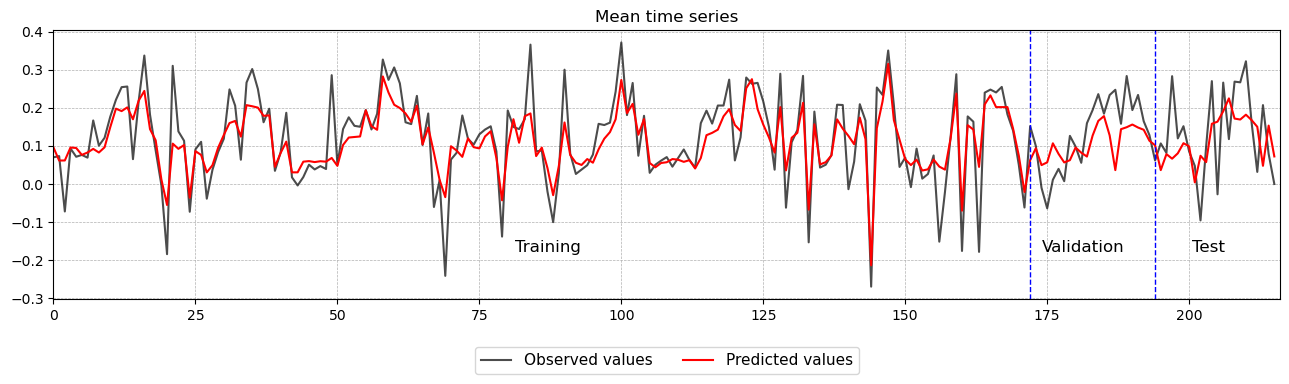

In [34]:
model.eval()
with torch.no_grad():
    y_pred_test = model(Timeseries_tensor)

predicted = scaler.inverse_transform(y_pred_test.cpu().numpy())
observed = scaler.inverse_transform(TTimeseries_tensor.cpu().numpy())
#observed = scaler.inverse_transform(TValidation_tensor.cpu().numpy())

# predicted = y_pred_test.cpu().numpy()
# observed = TTimeseries_tensor.cpu().numpy()

rmses = []
for i in range(predicted.shape[1]):
    rmse = np.sqrt(np.mean((predicted[:, i] - observed[:, i])**2))
    rmses.append(rmse)
    
best_rmse_index = np.argmin(rmses)
worst_rmse_index = np.argmax(rmses)

print(f'Mejor Serie de Tiempo (Serie {best_rmse_index+1}) - RMSE: {rmses[best_rmse_index]:.4f}')
print(f'Peor Serie de Tiempo (Serie {worst_rmse_index+1}) - RMSE: {rmses[worst_rmse_index]:.4f}')

plt.figure(figsize=(15, 3))
plt.plot(observed[:, best_rmse_index], label='Valores Reales', color="k")
plt.plot(predicted[:, best_rmse_index], label='Valores Predichos', linestyle='-', color="red", alpha=0.7)
plt.title(f'Mejor (Serie {best_rmse_index+1}) - RMSE: {rmses[best_rmse_index]:.4f}')
plt.legend(fontsize=8)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(observed[:, worst_rmse_index], label='Valores Reales', color="k")
plt.plot(predicted[:, worst_rmse_index], label='Valores Predichos', linestyle='-', color="red", alpha=0.7)
plt.title(f'Peor (Serie {worst_rmse_index+1}) - RMSE: {rmses[worst_rmse_index]:.4f}')
plt.legend(fontsize=8)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

print("RMSE promedio: ", np.mean(rmses))

plt.figure(figsize=(13, 4))
plt.plot(np.mean(observed, axis=1), color='k', linewidth=1.5, alpha=.7, label='Observed values')
plt.plot(np.mean(predicted, axis=1), label='Predicted values', linestyle='-', color="red", linewidth=1.5, alpha=1)
# Líneas punteadas para marcar las divisiones entre las fases
plt.axvline(x=len(XTrain)-lookback, color='blue', linestyle='--', linewidth=1)
plt.axvline(x=len(XTrain)+len(XValidation)-lookback, color='blue', linestyle='--', linewidth=1)
# Etiquetas para las fases
plt.text(len(XTrain) / 2, np.mean(observed) - 0.3, 'Training', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) / 3, np.mean(observed) - 0.3, 'Validation', fontsize=12, color='black', ha='center')
plt.text(len(XTrain) + len(XValidation) + len(XTest) / 3, np.mean(observed) - 0.3, 'Test', fontsize=12, color='black', ha='center')
# Ajustar los límites del eje x
plt.xlim(0, len(XTrain) + len(XValidation) + len(XTest) - lookback)
plt.title(f'Mean time series')
plt.legend(fontsize=11, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.grid(linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# plt.plot(np.mean(observed, axis=1), label='Real values', color="k")
# plt.plot(np.mean(predicted, axis=1), label='Predicted values', linestyle='-', color="red", alpha=0.7)
# plt.title(f'Mean time series')
# plt.legend(fontsize=8)
# plt.grid(linestyle = '--', linewidth = 0.5)
# plt.show()

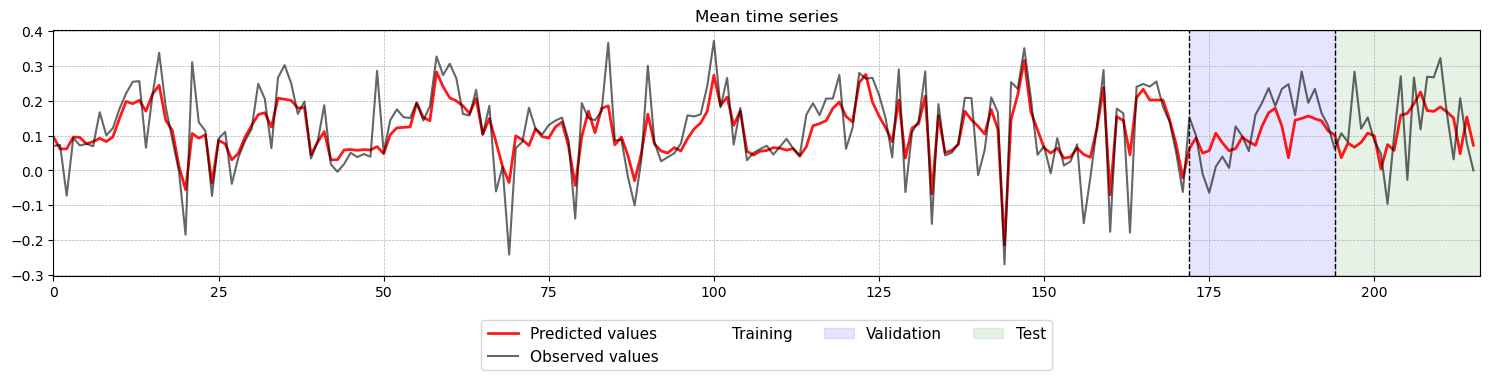

In [38]:
plt.figure(figsize=(15, 4))

plt.plot(np.mean(predicted, axis=1), label='Predicted values', linestyle='-', color="red", linewidth=2, alpha=.9)
plt.plot(np.mean(observed, axis=1), color='k', linewidth=1.5, alpha=.6, label='Observed values')

plt.axvspan(0, len(XTrain)-lookback, color='white', alpha=0.1, label='Training')

plt.axvspan(len(XTrain)-lookback, len(XTrain)+len(XValidation)-lookback, color='blue', alpha=0.1, label='Validation')

plt.axvspan(len(XTrain)+len(XValidation)-lookback, len(XTrain)+len(XValidation)+len(XTest)-lookback, color='green', alpha=0.1, label='Test')

plt.axvline(x=len(XTrain)-lookback, color='black', linestyle='--', linewidth=1)
plt.axvline(x=len(XTrain)+len(XValidation)-lookback, color='black', linestyle='--', linewidth=1)

plt.xlim(0, len(XTrain) + len(XValidation) + len(XTest) - lookback)

plt.title(f'Mean time series')
plt.legend(fontsize=11, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

plt.grid(linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()


In [39]:
3//2

1

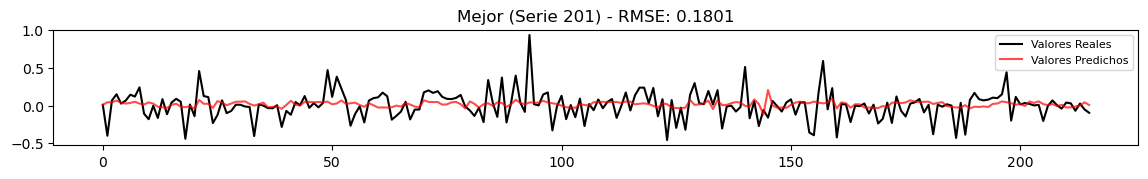

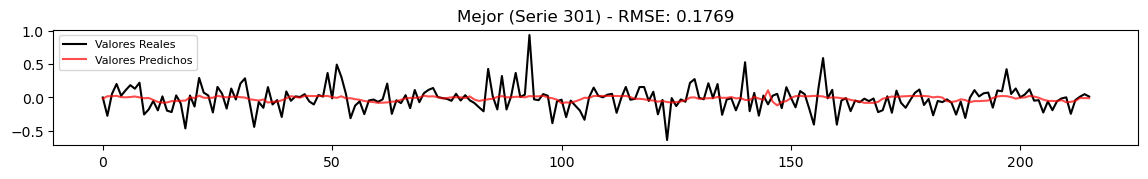

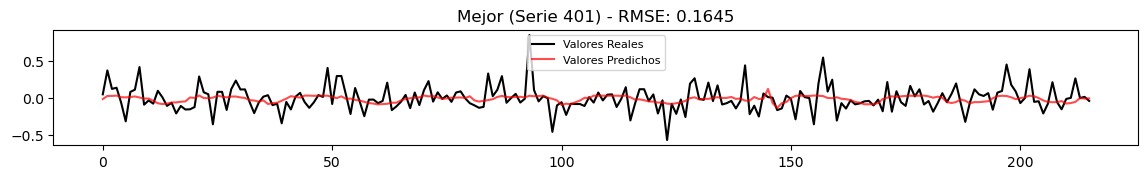

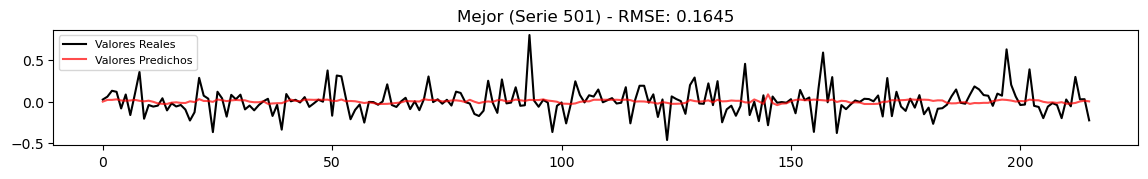

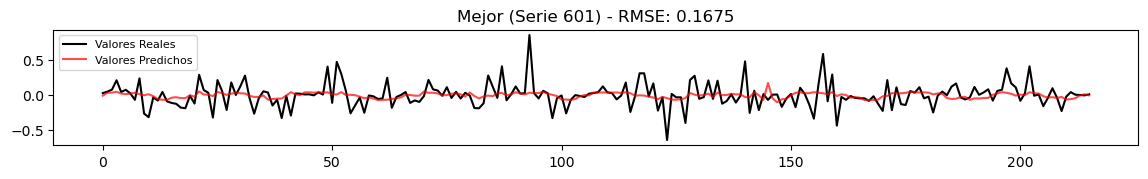

In [40]:
indices = [200, 300, 400, 500, 600]

for i in indices:
    plt.figure(figsize=(14, 1.5))
    plt.plot(observed[:, i], label='Valores Reales', color="k")
    plt.plot(predicted[:, i], label='Valores Predichos', linestyle='-', color="red", alpha=0.7)
    plt.title(f'Mejor (Serie {i+1}) - RMSE: {rmses[i]:.4f}')
    plt.legend(fontsize=8)
    plt.show()